In [1]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import time

import matplotlib.pyplot as plt


bucket_name = 'mountdata'
# Check if CUDA/GPU is available (optional but recommended for faster training)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
augment = False
'''
def preprocess_data_gcs(bucket_name, prefix):
    # Initialize lists to store images and labels
    images = []
    labels = []

    countries = os.listdir(os.path.join(bucket_name,prefix))
    # Iterate through the blobs
    for country in countries:
        for blob in os.listdir(os.path.join(bucket_name,prefix,country)):
            #print(blob)
            if 'orchard' in prefix:
                label = 0  # Assign class 0 if 'orchard' is in the filename
            else:
                label = 1  # Assign class 1 otherwise
    
            # Read and preprocess the image
            with open(os.path.join(bucket_name,prefix,country,blob), 'rb') as f:
                # Get the byte data of the image
                img_bytes = f.read()
                img = cv2.imdecode(np.frombuffer(img_bytes, np.uint8), cv2.IMREAD_GRAYSCALE)
                img = img[10:234, 10:234]  # Clip to central 50x50 pixels
        
                # Normalize pixel values to range [0, 1]
                img = img.astype('float32')# / 255.0
        
                # Append the preprocessed image and label to the lists
                images.append(img)
                labels.append(label)

    # Convert lists to numpy arrays
    images = np.array(images)
    labels = np.array(labels)

    return images, labels
'''
def preprocess_data_gcs(bucket_name, prefix):
  """Preprocesses data from Google Cloud Storage with augmentation.

  Args:
      bucket_name: Name of the bucket containing the data.
      prefix: Prefix of the folders containing images (e.g., "data/").

  Returns:
      A tuple of (images, labels):
          images: A numpy array of preprocessed images.
          labels: A numpy array of labels.
  """

  # Initialize lists to store images and labels
  images = []
  labels = []
  paths = []

  countries = os.listdir(os.path.join(bucket_name, prefix))
  # Iterate through the blobs
  for country in countries:
    for blob in os.listdir(os.path.join(bucket_name, prefix, country)):
      # Determine label based on prefix
      if 'orchard' in prefix:
        label = 0
      else:
        label = 1

      # Read and preprocess the image
      with open(os.path.join(bucket_name, prefix, country, blob), 'rb') as f:
        img_bytes = f.read()
        img = cv2.imdecode(np.frombuffer(img_bytes, np.uint8), cv2.IMREAD_GRAYSCALE)
        img = img[10:234, 10:234]  # Clip to central 50x50 pixels

        # Normalize pixel values (optional)
        img = img.astype('float32') / 255.0
        images.append(img)
        labels.append(label)
        paths.append(os.path.join(bucket_name, prefix, country, blob))
        # Create augmented versions
        if augment:
            augmented_images = []
            for angle in (90, 180, 270):  # Rotate by 90, 180, and 270 degrees
              rotated = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE * angle)
              augmented_images.append(rotated)
              paths.append(os.path.join(bucket_name, prefix, country, blob+'-rot'))
            flipped = cv2.flip(img, 1)  # Horizontally flip
            augmented_images.append(flipped)
            paths.append(os.path.join(bucket_name, prefix, country, blob+'flip'))
    
            # Add original and augmented images to final list
            images.extend(augmented_images)
            labels.extend([label] * len(augmented_images))  # Duplicate label for each image

  # Convert lists to numpy arrays
  #images = np.array(images)
  #labels = np.array(labels)
  return images, labels, paths




orchardpath = 'chmorchard-224m'
forestpath = 'chmforest-224m'

# Preprocess the data from GCS
print('beginning the orchard data preprocessing')
print(time.perf_counter())
images, labels, paths = preprocess_data_gcs(bucket_name, orchardpath)

print('finished the orchard data preprocessing')
print(time.perf_counter())

images2, labels2, paths2 = preprocess_data_gcs(bucket_name, forestpath)

print('finished the forest data preprocessing')
print(time.perf_counter())


beginning the orchard data preprocessing
13165.182655269
finished the orchard data preprocessing
13212.61398521
finished the forest data preprocessing
13246.780359036


In [ ]:
beginning the orchard data preprocessing
12529.03426078
finished the orchard data preprocessing
12572.21139201
finished the forest data preprocessing
12600.061072538

beginning the orchard data preprocessing
196.331051302
finished the orchard data preprocessing
1043.268731754
finished the forest data preprocessing
1478.389440114

In [ ]:
#7666 points unaugmented points total from Oil Palm, Coconut Palm, Releaf sampling, and SDPT Manual
#4056
#3610

#11494 points unaugmented points total from oil palm, coco, releaf, sdpt, benin, and ghana manual
#7817
#3677

In [3]:
print(len(images))
print(len(images2))

10294
8073


/bin/bash: line 1: nvidia-smi: command not found


In [4]:
!nvcc --version

/bin/bash: line 1: nvcc: command not found


In [7]:
'''
#labels = np.zeros(2339, dtype=int)
imgs = np.concatenate((images,images2))
labs = np.concatenate((labels,labels2))

print(imgs.shape)
print(labs)
#print(labels2)
print(labs.shape)
#print(labels)

# Split the data into train and validation sets (80-20 split)
train_images, val_images, train_labels, val_labels = train_test_split(imgs, labs, test_size=0.2, random_state=42)

# Convert numpy arrays to PyTorch tensors
train_images_tensor = torch.tensor(train_images).unsqueeze(1)  # Add a channel dimension
train_labels_tensor = torch.tensor(train_labels)
val_images_tensor = torch.tensor(val_images).unsqueeze(1)  # Add a channel dimension
val_labels_tensor = torch.tensor(val_labels)

# Create DataLoader for training and validation sets
train_dataset = TensorDataset(train_images_tensor, train_labels_tensor)
val_dataset = TensorDataset(val_images_tensor, val_labels_tensor)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

# Instantiate the model, loss function, and optimizer
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

trn_acc_list = []
val_acc_list = []
trn_loss_list = []
val_loss_list = []

# Train the model
num_epochs = 25
for epoch in range(num_epochs):
    model.train()
    correct = 0
    total = 0
    train_loss = 0.0
    for inputs, labs in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        print(inputs.shape)
        print(labs.shape)
        print(outputs.shape)

        loss = criterion(outputs, labs)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labs.size(0)
        correct += (predicted == labs).sum().item()
    trn_acc_list.append(correct/total * 100)
    trn_loss_list.append(train_loss/len(train_loader.dataset))

    # Validate the model
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labs in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labs)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labs.size(0)
            correct += (predicted == labs).sum().item()
        val_acc_list.append(correct/total * 100)
        val_loss_list.append(val_loss / len(val_loader.dataset))

    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Train Loss: {train_loss/len(train_loader.dataset):.4f}, '
          f'Val Loss: {val_loss/len(val_loader.dataset):.4f}, '
          f'Val Acc: {(correct/total)*100:.2f}%')


# Extract the training and validation accuracy from the model history
train_accuracy = trn_acc_list
val_accuracy = val_acc_list

# Get the number of epochs
epochs = range(len(train_accuracy))

# Create the plot
plt.plot(epochs, train_accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Extract the training and validation accuracy from the model history
train_losses = trn_loss_list
val_losses = val_loss_list

# Get the number of epochs
epochs = range(len(train_accuracy))

# Create the plot
plt.plot(epochs, train_losses, label='Training loss')
plt.plot(epochs, val_losses, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()
'''

"\n#labels = np.zeros(2339, dtype=int)\nimgs = np.concatenate((images,images2))\nlabs = np.concatenate((labels,labels2))\n\nprint(imgs.shape)\nprint(labs)\n#print(labels2)\nprint(labs.shape)\n#print(labels)\n\n# Split the data into train and validation sets (80-20 split)\ntrain_images, val_images, train_labels, val_labels = train_test_split(imgs, labs, test_size=0.2, random_state=42)\n\n# Convert numpy arrays to PyTorch tensors\ntrain_images_tensor = torch.tensor(train_images).unsqueeze(1)  # Add a channel dimension\ntrain_labels_tensor = torch.tensor(train_labels)\nval_images_tensor = torch.tensor(val_images).unsqueeze(1)  # Add a channel dimension\nval_labels_tensor = torch.tensor(val_labels)\n\n# Create DataLoader for training and validation sets\ntrain_dataset = TensorDataset(train_images_tensor, train_labels_tensor)\nval_dataset = TensorDataset(val_images_tensor, val_labels_tensor)\n\ntrain_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)\nval_loader = DataLoader(va

In [3]:
import torch
import torch.nn as nn
import torchvision.models as models

augment = False

class CustomResNet(nn.Module):
    def __init__(self):
        super(CustomResNet, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        # Modify the first convolution layer to accept single-channel input
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        # If you're using a different model, adjust the input layer accordingly

    def forward(self, x):
        return self.resnet(x)

# Create an instance of the custom ResNet model
model = CustomResNet()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
imgs = np.concatenate((images,images2))
labs = np.concatenate((labels,labels2))
pths = np.concatenate((paths,paths2))



# Split the data into train and validation sets (80-20 split)
#train_images, val_images, train_labels, val_labels, train_paths, val_paths = train_test_split(imgs, labs, pths, test_size=0.2, random_state=42)
train_images, val_images, train_labels, val_labels = train_test_split(imgs, labs, test_size=0.2, random_state=42)


'''
for img, lab in zip(train_images, train_labels):
    augmented_images = []
    for angle in (90, 180, 270):  # Rotate by 90, 180, and 270 degrees
      rotated = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE * angle)
      augmented_images.append(rotated)
      #paths.append(os.path.join(bucket_name, prefix, country, blob+'-rot'))
    flipped = cv2.flip(img, 1)  # Horizontally flip
    augmented_images.append(flipped)
    #paths.append(os.path.join(bucket_name, prefix, country, blob+'flip'))

    train_images = np.concatenate((train_images,augmented_images))
    train_labels = np.concatenate((train_labels,([lab] * len(augmented_images))))
'''

def augment_images(images, labels, num_rotations=3, flip=True):
  """
  Augments images with rotations and flips.

  Args:
    images: A NumPy array of images (shape: [num_images, height, width, channels]).
    labels: A NumPy array of labels (shape: [num_images]).
    num_rotations: Number of random rotations to apply (default: 3).
    flip: Whether to perform horizontal flip (default: True).

  Returns:
    A tuple containing two NumPy arrays: the augmented images and the
    corresponding labels.
  """

  # Pre-compute rotation matrices for efficiency
  rotation_matrices = [cv2.getRotationMatrix2D((images[0].shape[1] // 2, images[0].shape[0] // 2), angle, 1.0)
                        for angle in np.random.randint(0, 360, size=num_rotations)]

  # Create empty lists to store augmented data (avoid unnecessary copies)
  augmented_images = []
  augmented_labels = []

  for img, lab in zip(images, labels):
    augmented_images.append(img)
    augmented_labels.append(lab)

    # Apply random rotations
    for rotation_matrix in rotation_matrices:
      rotated = cv2.warpAffine(img, rotation_matrix, (img.shape[1], img.shape[0]))
      augmented_images.append(rotated)
      augmented_labels.append(lab)

    # Perform horizontal flip if desired
    if flip:
      flipped = cv2.flip(img, 1)
      augmented_images.append(flipped)
      augmented_labels.append(lab)

  return np.array(augmented_images), np.array(augmented_labels)


if augment:
        
    print('beginning the augmentation')
    print(time.perf_counter())
    train_images, train_labels = augment_images(train_images,train_labels)
    print('finish the augmentation')
    print(time.perf_counter())

# Convert numpy arrays to PyTorch tensors
#train_images_tensor = torch.tensor(train_images).byte().unsqueeze(1)  # Add a channel dimension
train_images_tensor = torch.tensor(train_images).unsqueeze(1)  # Add a channel dimension
#print(train_images_tensor.dtype)
train_labels_tensor = torch.tensor(train_labels)
val_images_tensor = torch.tensor(val_images).unsqueeze(1)  # Add a channel dimension
#print(val_images_tensor.dtype)
val_labels_tensor = torch.tensor(val_labels)
#train_paths_tensor = torch.tensor(train_paths)
#val_paths_tensor = torch.tensor(val_paths)

# Create DataLoader for training and validation sets
train_dataset = TensorDataset(train_images_tensor, train_labels_tensor)#, train_paths_tensor)
val_dataset = TensorDataset(val_images_tensor, val_labels_tensor)#, val_paths_tensor)

'''
class ImageLabelPathDataset(torch.utils.data.Dataset):
  def __init__(self, images, labels, paths):
    self.images = images
    self.labels = labels
    self.paths = paths

  def __len__(self):
    return len(self.images)

  def __getitem__(self, index):
    image = torch.tensor(self.images[index]).unsqueeze(1)
    label = torch.tensor(self.labels[index])
    path = self.paths[index]
    return image, label, path

# Use the custom dataset class
train_dataset = ImageLabelPathDataset(train_images, train_labels, train_paths)
val_dataset = ImageLabelPathDataset(val_images, val_labels, val_paths)
'''
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)



# Instantiate the model, loss function, and optimizer
#model = SimpleCNN(num_classes)
#criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters(), lr=0.001)


/home/angelats11/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
print(len(train_dataset))
print(len(val_dataset))

#AUGMENTED SIZE
#73465
#3674

14693
3674


training start
Epoch 1/20, Train Loss: 0.7477, Train Acc: 69.9517, Val Loss: 0.8242, Val Acc: 70.99
Epoch 2/20, Train Loss: 0.4932, Train Acc: 75.4645, Val Loss: 0.6378, Val Acc: 64.97
Epoch 3/20, Train Loss: 0.4634, Train Acc: 77.4314, Val Loss: 0.7839, Val Acc: 70.96
Epoch 4/20, Train Loss: 0.4353, Train Acc: 79.0853, Val Loss: 0.6080, Val Acc: 72.48
Epoch 5/20, Train Loss: 0.4161, Train Acc: 80.0041, Val Loss: 0.8012, Val Acc: 68.75
Epoch 6/20, Train Loss: 0.3847, Train Acc: 82.1139, Val Loss: 0.5363, Val Acc: 74.06
Epoch 7/20, Train Loss: 0.3775, Train Acc: 82.8286, Val Loss: 0.8082, Val Acc: 74.41
Epoch 8/20, Train Loss: 0.3419, Train Acc: 84.7410, Val Loss: 0.6777, Val Acc: 76.29
Epoch 9/20, Train Loss: 0.2992, Train Acc: 86.9121, Val Loss: 0.7015, Val Acc: 69.73
Epoch 10/20, Train Loss: 0.2559, Train Acc: 88.9880, Val Loss: 0.8020, Val Acc: 75.80
Epoch 11/20, Train Loss: 0.2214, Train Acc: 90.8324, Val Loss: 0.7003, Val Acc: 71.34
Epoch 12/20, Train Loss: 0.1796, Train Acc: 92.6

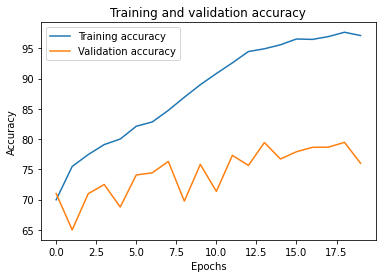

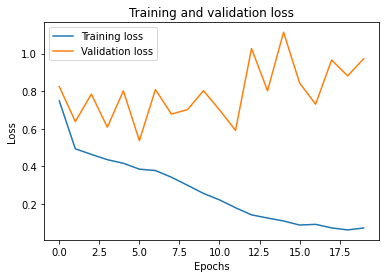

In [5]:
print('training start')
trn_acc_list = []
val_acc_list = []
trn_loss_list = []
val_loss_list = []

# Train the model
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    correct = 0
    total = 0
    train_loss = 0.0
    for inputs, labs in train_loader:
        inputs= inputs.to("cuda")
        labs = torch.Tensor(labs).to("cuda")
        
#        print('inputs type')
#        print(inputs.dtype)
        #inputs.byte()
#        print(inputs.dtype)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labs)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labs.size(0)
        correct += (predicted == labs).sum().item()
    trn_acc_list.append(correct/total * 100)
    trn_loss_list.append(train_loss/len(train_loader.dataset))

    if epoch % 9 == 0: 
        torch.save(model.state_dict(), 'resnet-continental-unaugmented-pretrained.pt')


    # Validate the model
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labs in val_loader:
            inputs= inputs.to("cuda")
            labs = torch.Tensor(labs).to("cuda")
        
            outputs = model(inputs)
            loss = criterion(outputs, labs)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labs.size(0)
            correct += (predicted == labs).sum().item()
        val_acc_list.append(correct/total * 100)
        val_loss_list.append(val_loss / len(val_loader.dataset))

    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Train Loss: {train_loss/len(train_loader.dataset):.4f}, '
          f'Train Acc: {trn_acc_list[-1]:.4f}, '
          #f'Train Acc: {trn_acc_list[-1])*100:.4f}, '
          f'Val Loss: {val_loss/len(val_loader.dataset):.4f}, '
          f'Val Acc: {(correct/total)*100:.2f}' )


# Extract the training and validation accuracy from the model history
train_accuracy = trn_acc_list
val_accuracy = val_acc_list

# Get the number of epochs
epochs = range(len(train_accuracy))

# Create the plot
plt.plot(epochs, train_accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Extract the training and validation accuracy from the model history
train_losses = trn_loss_list
val_losses = val_loss_list

# Get the number of epochs
epochs = range(len(train_accuracy))

# Create the plot
plt.plot(epochs, train_losses, label='Training loss')
plt.plot(epochs, val_losses, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

#previously: leak-free resulted in overfitting by epoch 3 with a peak val acc ~80%. 

In [12]:
print(len(images))
print(len(images2))

8209
4402


In [13]:

print(trn_acc_list)
print(val_acc_list)
print(trn_loss_list)
print(val_loss_list)

[80.0039651070579, 80.91593973037273, 81.65344964314036, 82.54758128469469, 83.49524187153054, 84.55987311657415, 86.02894528152261, 88.12053925455987, 90.43021411578113, 92.753766851705, 94.01665344964314, 95.21015067406819, 95.39056304520223, 96.5107057890563, 96.80610626486916, 95.92188739095955, 97.48810467882633, 97.5832672482157, 97.67644726407613, 97.78350515463917]
[73.880301228696, 75.18826793499802, 79.74633372968688, 80.02378121284185, 79.90487514863258, 80.42013476020611, 78.16091954022988, 77.60602457391994, 80.49940546967895, 80.93539437177962, 77.72493063812921, 79.23107411811336, 81.45065398335315, 81.0543004359889, 77.09076496234641, 81.45065398335315, 79.98414585810542, 79.23107411811336, 81.64883075703527, 80.42013476020611]
[0.4141066891441829, 0.3968534010256405, 0.38294556673134633, 0.3706312950975265, 0.35370013413922735, 0.3327956120047089, 0.3063672176057814, 0.2670450063190415, 0.2200828414578744, 0.17205400632356105, 0.14277900928819018, 0.11473462218972637, 

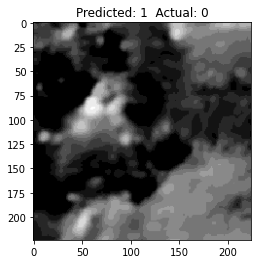

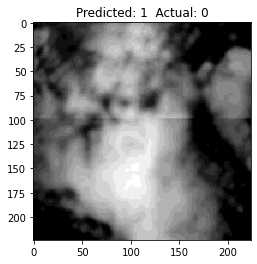

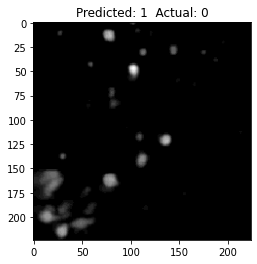

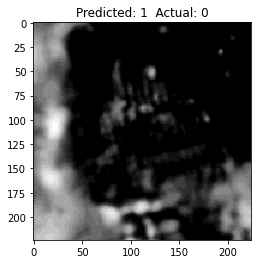

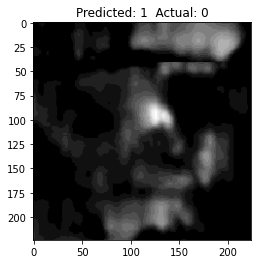

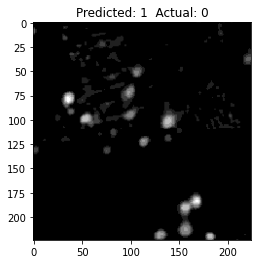

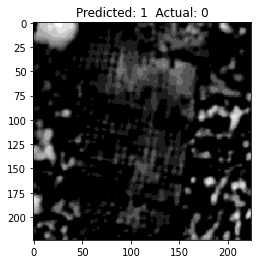

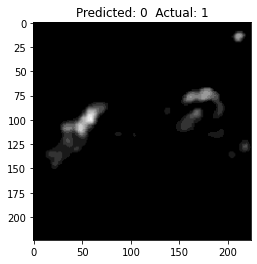

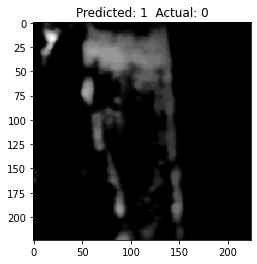

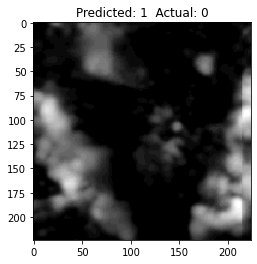

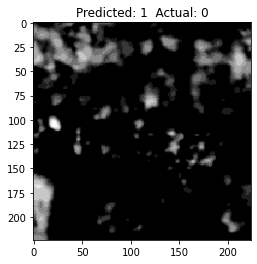

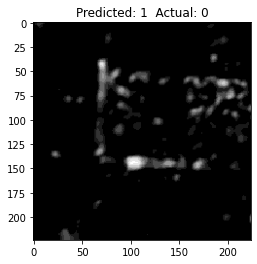

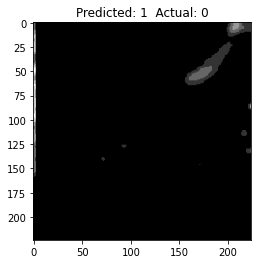

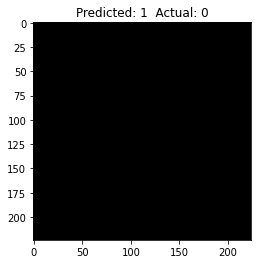

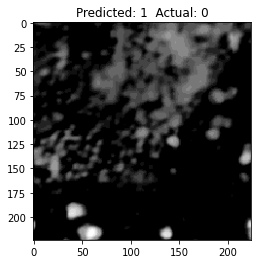

Confusion Matrix:
 [[1432  652]
 [ 230 1360]]
True Positives: 1360
False Positives: 652
True Negatives: 1432
False Negatives: 230
Precision: 0.6759
Recall: 0.8553
acc %
75.99346761023408
total INCORRECT total examples in val number of correct examples in val
882 3674 2792
val loss
0.9718233233051061


In [6]:
model.eval()
val_loss = 0.0
correct = 0
total = 0
all_predictions = []
all_labels = []
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt  # Import for image display

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs= inputs.to("cuda")
        labels = torch.Tensor(labels).to("cuda")
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        val_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Append predictions and labels for confusion matrix calculation
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        misclassified_inds = (predicted != labels).nonzero(as_tuple=True)[0]
        for misclassified_ind in misclassified_inds:
            if misclassified_ind % 300 == 0:
                misclassified_image = inputs[misclassified_ind].cpu().squeeze()  # Get misclassified image
                misclassified_image = misclassified_image.numpy()
                
                plt.imshow(misclassified_image,cmap='gray')
                plt.title(f"Predicted: {predicted[misclassified_ind].item()}  Actual: {labels[misclassified_ind].item()}")
                plt.show()  # Display the misclassified image


# Calculate confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Extract true positives, negatives, false positives, and negatives
tn, fp, fn, tp = cm.ravel()

# Calculate Precision, Recall
precision = tp / (tp + fp)
recall = tp / (tp + fn)

# Print results (you can modify this for your needs)
print(f"Confusion Matrix:\n {cm}")
print(f"True Positives: {tp}")
print(f"False Positives: {fp}")
print(f"True Negatives: {tn}")
print(f"False Negatives: {fn}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print('acc %')
print(correct/total * 100)
print('total INCORRECT', 'total examples in val', 'number of correct examples in val')
print(total-correct, total, correct)
print('val loss')
print(val_loss / len(val_loader.dataset))

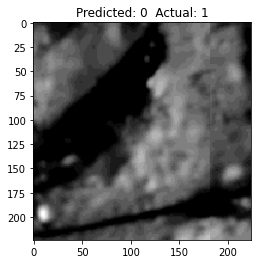

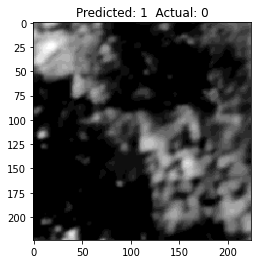

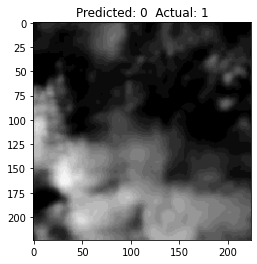

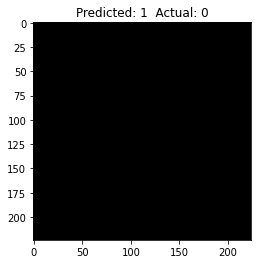

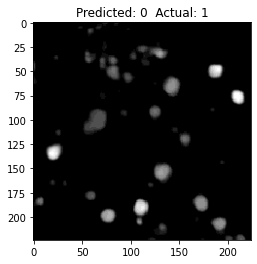

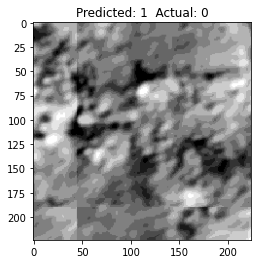

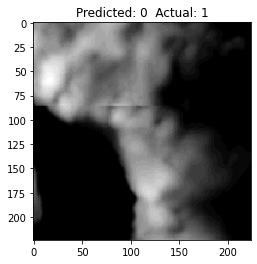

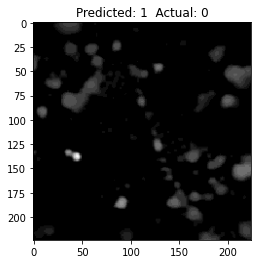

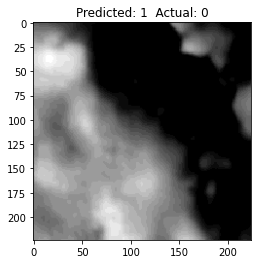

Confusion Matrix:
 [[566 265]
 [170 533]]
True Positives: 533
False Positives: 265
True Negatives: 566
False Negatives: 170
Precision: 0.6679
Recall: 0.7582
acc %
71.64276401564538
total INCORRECT total examples in val number of correct examples in val
435 1534 1099
val loss
1.0162414313139785


In [20]:
from sklearn.metrics import confusion_matrix

model2 = CustomResNet()
model2.load_state_dict(torch.load('resnet-unaugmented.pt'))
model2.eval()
val_loss = 0.0
correct = 0
total = 0
all_predictions = []
all_labels = []

import matplotlib.pyplot as plt  # Import for image display

with torch.no_grad():
    for inputs, labels in val_loader:
        outputs = model2(inputs)
        loss = criterion(outputs, labels)
        val_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Append predictions and labels for confusion matrix calculation
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        misclassified_inds = (predicted != labels).nonzero(as_tuple=True)[0]
        for misclassified_ind in misclassified_inds:
            if misclassified_ind % 500 == 0:
                misclassified_image = inputs[misclassified_ind].cpu().squeeze()  # Get misclassified image
                misclassified_image = misclassified_image.numpy()
                
                plt.imshow(misclassified_image,cmap='gray')
                plt.title(f"Predicted: {predicted[misclassified_ind].item()}  Actual: {labels[misclassified_ind].item()}")
                plt.show()  # Display the misclassified image


# Calculate confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Extract true positives, negatives, false positives, and negatives
tn, fp, fn, tp = cm.ravel()

# Calculate Precision, Recall
precision = tp / (tp + fp)
recall = tp / (tp + fn)

# Print results (you can modify this for your needs)
print(f"Confusion Matrix:\n {cm}")
print(f"True Positives: {tp}")
print(f"False Positives: {fp}")
print(f"True Negatives: {tn}")
print(f"False Negatives: {fn}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print('acc %')
print(correct/total * 100)
print('total INCORRECT', 'total examples in val', 'number of correct examples in val')
print(total-correct, total, correct)
print('val loss')
print(val_loss / len(val_loader.dataset))

training start


/home/angelats11/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/20, Train Loss: 0.6898, Train Acc: 66.7393, Val Loss: 0.6161, Val Acc: 66.79
Epoch 2/20, Train Loss: 0.5753, Train Acc: 69.1214, Val Loss: 0.5942, Val Acc: 69.46
Epoch 3/20, Train Loss: 0.5425, Train Acc: 71.7280, Val Loss: 0.7236, Val Acc: 56.91
Epoch 4/20, Train Loss: 0.5212, Train Acc: 73.2662, Val Loss: 0.5364, Val Acc: 71.72
Epoch 5/20, Train Loss: 0.5086, Train Acc: 74.1169, Val Loss: 0.4878, Val Acc: 75.83
Epoch 6/20, Train Loss: 0.4937, Train Acc: 74.8452, Val Loss: 0.5335, Val Acc: 73.65
Epoch 7/20, Train Loss: 0.4734, Train Acc: 76.2880, Val Loss: 1.3373, Val Acc: 40.61
Epoch 8/20, Train Loss: 0.4717, Train Acc: 76.5603, Val Loss: 0.5260, Val Acc: 73.95
Epoch 9/20, Train Loss: 0.4630, Train Acc: 77.1388, Val Loss: 0.5301, Val Acc: 74.44
Epoch 10/20, Train Loss: 0.4583, Train Acc: 77.3498, Val Loss: 0.4953, Val Acc: 76.02
Epoch 11/20, Train Loss: 0.4499, Train Acc: 78.4387, Val Loss: 0.4625, Val Acc: 76.57
Epoch 12/20, Train Loss: 0.4365, Train Acc: 78.8471, Val Loss: 

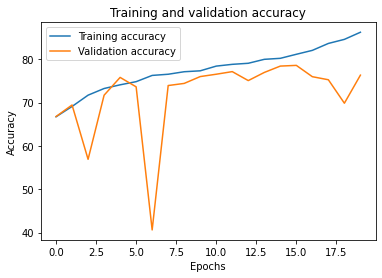

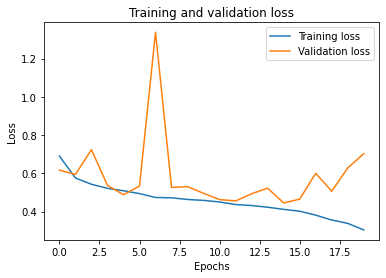

In [7]:
###########################################
########NO FINE-TUNE-- train from scratch
###########################################
class CustomResNet(nn.Module):
    def __init__(self):
        super(CustomResNet, self).__init__()
        self.resnet = models.resnet18(pretrained=False)
        # Modify the first convolution layer to accept single-channel input
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        # If you're using a different model, adjust the input layer accordingly

    def forward(self, x):
        return self.resnet(x)

# Create an instance of the custom ResNet model
model = CustomResNet()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


print('training start')
trn_acc_list = []
val_acc_list = []
trn_loss_list = []
val_loss_list = []

# Train the model
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    correct = 0
    total = 0
    train_loss = 0.0
    for inputs, labs in train_loader:
        inputs= inputs.to("cuda")
        labs = torch.Tensor(labs).to("cuda")
        
#        print('inputs type')
#        print(inputs.dtype)
        #inputs.byte()
#        print(inputs.dtype)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labs)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labs.size(0)
        correct += (predicted == labs).sum().item()
    trn_acc_list.append(correct/total * 100)
    trn_loss_list.append(train_loss/len(train_loader.dataset))

    if epoch % 9 == 0: 
        torch.save(model.state_dict(), 'resnet-continental-unaugmented-scratch.pt')


    # Validate the model
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labs in val_loader:
            inputs= inputs.to("cuda")
            labs = torch.Tensor(labs).to("cuda")
        
            outputs = model(inputs)
            loss = criterion(outputs, labs)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labs.size(0)
            correct += (predicted == labs).sum().item()
        val_acc_list.append(correct/total * 100)
        val_loss_list.append(val_loss / len(val_loader.dataset))

    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Train Loss: {train_loss/len(train_loader.dataset):.4f}, '
          f'Train Acc: {trn_acc_list[-1]:.4f}, '
          #f'Train Acc: {trn_acc_list[-1])*100:.4f}, '
          f'Val Loss: {val_loss/len(val_loader.dataset):.4f}, '
          f'Val Acc: {(correct/total)*100:.2f}' )


# Extract the training and validation accuracy from the model history
train_accuracy = trn_acc_list
val_accuracy = val_acc_list

# Get the number of epochs
epochs = range(len(train_accuracy))

# Create the plot
plt.plot(epochs, train_accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Extract the training and validation accuracy from the model history
train_losses = trn_loss_list
val_losses = val_loss_list

# Get the number of epochs
epochs = range(len(train_accuracy))

# Create the plot
plt.plot(epochs, train_losses, label='Training loss')
plt.plot(epochs, val_losses, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [10]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)  # Input channel = 1, Output channels = 32
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Downsample
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)  # Output channels = 64
        self.fc1 = nn.Linear(64 * 56 * 56, 128)  # Flatten and connect to fully-connected layer
        self.fc2 = nn.Linear(128, 1)  # Output layer with 1 neuron for binary classification

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # Apply ReLU activation and pooling
        x = self.pool(torch.relu(self.conv2(x)))  # Apply ReLU activation and pooling again
        x = torch.flatten(x, 1)  # Flatten
        x = torch.relu(self.fc1(x))  # Apply ReLU activation
        x = torch.sigmoid(self.fc2(x))  # Apply sigmoid activation for binary output
        return x

# Create an instance of the CNN
model = SimpleCNN()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


print('training start')
trn_acc_list = []
val_acc_list = []
trn_loss_list = []
val_loss_list = []

# Train the model
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    correct = 0
    total = 0
    train_loss = 0.0
    for inputs, labs in train_loader:
        inputs= inputs.to("cuda")
        labs = torch.Tensor(labs).to("cuda")
        
#        print('inputs type')
#        print(inputs.dtype)
        #inputs.byte()
#        print(inputs.dtype)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labs)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labs.size(0)
        correct += (predicted == labs).sum().item()
    trn_acc_list.append(correct/total * 100)
    trn_loss_list.append(train_loss/len(train_loader.dataset))

    if epoch % 9 == 0: 
        torch.save(model.state_dict(), 'cnn-continental-augmented.pt')


    # Validate the model
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labs in val_loader:
            inputs= inputs.to("cuda")
            labs = torch.Tensor(labs).to("cuda")
        
            outputs = model(inputs)
            loss = criterion(outputs, labs)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labs.size(0)
            correct += (predicted == labs).sum().item()
        val_acc_list.append(correct/total * 100)
        val_loss_list.append(val_loss / len(val_loader.dataset))

    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Train Loss: {train_loss/len(train_loader.dataset):.4f}, '
          f'Train Acc: {trn_acc_list[-1]:.4f}, '
          #f'Train Acc: {trn_acc_list[-1])*100:.4f}, '
          f'Val Loss: {val_loss/len(val_loader.dataset):.4f}, '
          f'Val Acc: {(correct/total)*100:.2f}' )


# Extract the training and validation accuracy from the model history
train_accuracy = trn_acc_list
val_accuracy = val_acc_list

# Get the number of epochs
epochs = range(len(train_accuracy))

# Create the plot
plt.plot(epochs, train_accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Extract the training and validation accuracy from the model history
train_losses = trn_loss_list
val_losses = val_loss_list

# Get the number of epochs
epochs = range(len(train_accuracy))

# Create the plot
plt.plot(epochs, train_losses, label='Training loss')
plt.plot(epochs, val_losses, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


training start


../aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [1,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [4,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [8,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [9,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [12,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [13,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/Loss.cu:250: nll_loss

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [8]:

from functools import partial

import torch
import torch.nn as nn

import timm.models.vision_transformer
from pos_embed import get_2d_sincos_pos_embed


class VisionTransformer(timm.models.vision_transformer.VisionTransformer):
    """ Vision Transformer with support for global average pooling
    """
    def __init__(self, global_pool=False, **kwargs):
        super(VisionTransformer, self).__init__(**kwargs)

        # Added by Samar, need default pos embedding
        pos_embed = get_2d_sincos_pos_embed(self.pos_embed.shape[-1], int(self.patch_embed.num_patches ** .5),
                                            cls_token=True)
        self.pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))

        self.global_pool = global_pool
        if self.global_pool:
            norm_layer = kwargs['norm_layer']
            embed_dim = kwargs['embed_dim']
            self.fc_norm = norm_layer(embed_dim)

            del self.norm  # remove the original norm

    def forward_features(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)

        cls_tokens = self.cls_token.expand(B, -1, -1)  # stole cls_tokens impl from Phil Wang, thanks
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        x = self.pos_drop(x)

        for blk in self.blocks:
            x = blk(x)

        if self.global_pool:
            x = x[:, 1:, :].mean(dim=1)  # global pool without cls token
            outcome = self.fc_norm(x)
        else:
            x = self.norm(x)
            outcome = x[:, 0]

        return outcome


def vit_base_patch16(**kwargs):
    model = VisionTransformer(
        embed_dim=768, depth=12, num_heads=12, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model


def vit_large_patch16(**kwargs):
    model = VisionTransformer(
        embed_dim=1024, depth=24, num_heads=16, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model


def vit_huge_patch14(**kwargs):
    model = VisionTransformer(
        embed_dim=1280, depth=32, num_heads=16, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model

Epoch 1/20, Train Loss: 0.7391, Val Loss: 0.6966, Val Acc: 54.44%
Epoch 2/20, Train Loss: 0.6591, Val Loss: 0.6423, Val Acc: 63.47%
Epoch 3/20, Train Loss: 0.6466, Val Loss: 0.6477, Val Acc: 64.02%
Epoch 4/20, Train Loss: 0.6386, Val Loss: 0.6556, Val Acc: 62.71%
Epoch 5/20, Train Loss: 0.6435, Val Loss: 0.6520, Val Acc: 63.09%
Epoch 6/20, Train Loss: 0.6551, Val Loss: 0.6301, Val Acc: 65.19%
Epoch 7/20, Train Loss: 0.6402, Val Loss: 0.6361, Val Acc: 64.73%
Epoch 8/20, Train Loss: 0.6367, Val Loss: 0.6291, Val Acc: 64.37%
Epoch 9/20, Train Loss: 0.6275, Val Loss: 0.6405, Val Acc: 63.66%
Epoch 10/20, Train Loss: 0.6291, Val Loss: 0.6215, Val Acc: 64.94%
Epoch 11/20, Train Loss: 0.6229, Val Loss: 0.6271, Val Acc: 64.53%
Epoch 12/20, Train Loss: 0.6221, Val Loss: 0.6209, Val Acc: 64.43%
Epoch 13/20, Train Loss: 0.6242, Val Loss: 0.6323, Val Acc: 64.56%
Epoch 14/20, Train Loss: 0.6175, Val Loss: 0.6243, Val Acc: 65.02%
Epoch 15/20, Train Loss: 0.6190, Val Loss: 0.6332, Val Acc: 63.66%
Epoc

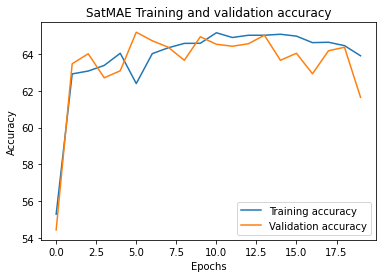

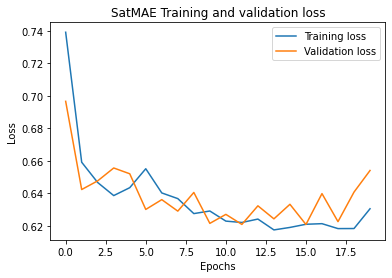

In [9]:
device = torch.device('cuda')

model = VisionTransformer()
model.to(device)
model.load_state_dict(torch.load('pretrain-vit-base-e199.pth'), strict=False)
#model.load_pretrained('pretrain-vit-base-e199.pth')
#model = create_model('vit_base_patch16', pretrained=True)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

trn_acc_list = []
val_acc_list = []
trn_loss_list = []
val_loss_list = []

def triplicate_channel(data):
  """
  Triplicates the channel dimension of a PyTorch tensor batch.

  Args:
    batch: A dictionary or tuple containing the data loaded by a DataLoader.
      Usually, the key 'data' holds the actual tensor batch.

  Returns:
    A dictionary or tuple with the same structure as the input, but with the 
    data tensor having its channel dimension triplicated.
  """
  # Assuming the data is in the key 'data' within the batch
  #data = batch['data']
  if len(data.shape) == 3:
    # Add a new dimension of size 1 for the missing channel
    data = data.unsqueeze(1)
    # Repeat the channel 3 times
    repeated_channel = data.repeat(1, 3, 1, 1)
  elif len(data.shape) == 4 and data.shape[1] == 1:
    # Existing single channel, repeat it 3 times
    repeated_channel = data.repeat(1, 3, 1, 1)
  else:
    # Already has 3 or more channels, no change needed
    repeated_channel = data
  #return {key: value for key, value in batch.items() if key != 'data'} | {'data': repeated_channel}
  return repeated_channel


# Train the model
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    correct = 0
    total = 0
    train_loss = 0.0
    for inputs, labels in train_loader:
        inputs = triplicate_channel(inputs).to(device)
        labels = torch.Tensor(labels).to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    trn_acc_list.append(correct/total * 100)
    trn_loss_list.append(train_loss/len(train_loader.dataset))

    
    if epoch % 9 == 0: 
        torch.save(model.state_dict(), 'vit-unaugmented-pretrain.pt')


    # Validate the model
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = triplicate_channel(inputs).to(device)
            labels = torch.Tensor(labels).to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        val_acc_list.append(correct/total * 100)
        val_loss_list.append(val_loss / len(val_loader.dataset))

    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Train Loss: {train_loss/len(train_loader.dataset):.4f}, '
          f'Val Loss: {val_loss/len(val_loader.dataset):.4f}, '
          f'Val Acc: {(correct/total)*100:.2f}%')

#history = model.history()


import matplotlib.pyplot as plt

# Extract the training and validation accuracy from the model history
train_accuracy = trn_acc_list
val_accuracy = val_acc_list

# Get the number of epochs
epochs = range(len(train_accuracy))

# Create the plot
plt.plot(epochs, train_accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('SatMAE Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Extract the training and validation accuracy from the model history
train_losses = trn_loss_list
val_losses = val_loss_list

# Get the number of epochs
epochs = range(len(train_accuracy))

# Create the plot
plt.plot(epochs, train_losses, label='Training loss')
plt.plot(epochs, val_losses, label='Validation loss')
plt.title('SatMAE Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


True

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 16769  100 16769    0     0   121k      0 --:--:-- --:--:-- --:--:--  121k


In [40]:
!sudo nvidia-smi


sudo: nvidia-smi: command not found


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  linux-compiler-gcc-10-x86 linux-headers-5.10.0-29-common linux-kbuild-5.10
The following NEW packages will be installed:
  linux-compiler-gcc-10-x86 linux-headers-5.10.0-29-cloud-amd64
  linux-headers-5.10.0-29-common linux-kbuild-5.10
0 upgraded, 4 newly installed, 0 to remove and 7 not upgraded.
Need to get 11.8 MB of archives.
After this operation, 59.4 MB of additional disk space will be used.
Do you want to continue? [Y/n] ^C
sudo: add-apt-repository: command not found
OK
/bin/bash: line 1: distro: No such file or directory


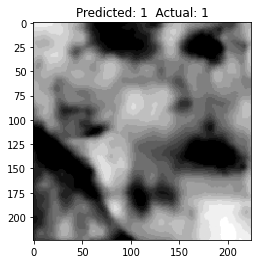

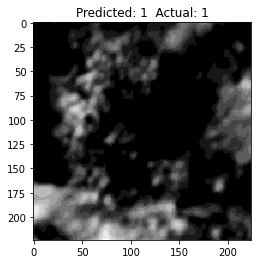

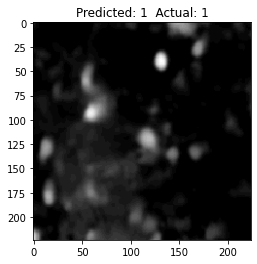

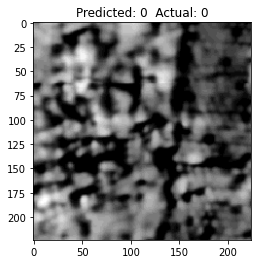

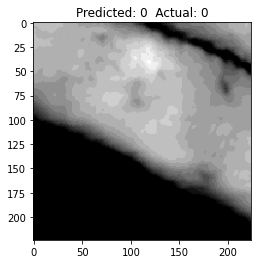

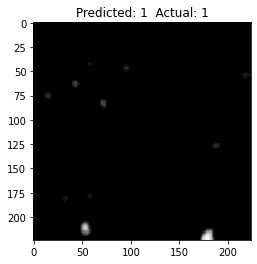

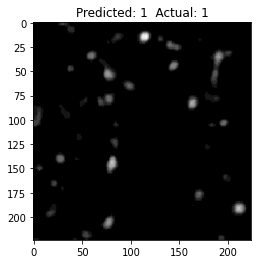

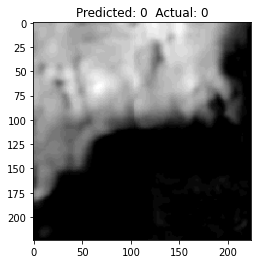

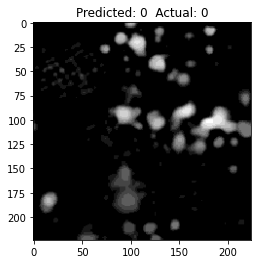

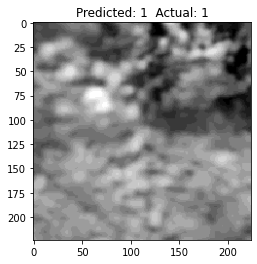

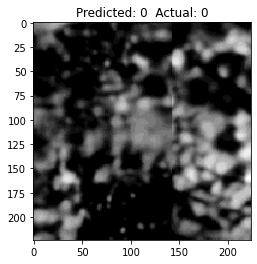

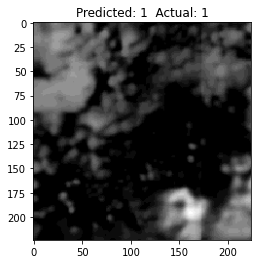

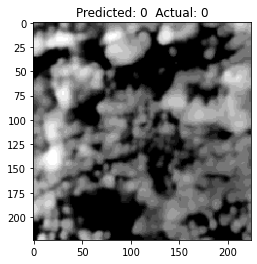

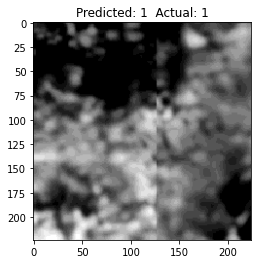

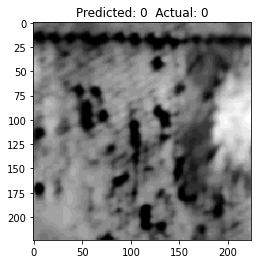

In [21]:
with torch.no_grad():
    for inputs, labels in val_loader:
        outputs = model2(inputs)
        loss = criterion(outputs, labels)
        val_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Append predictions and labels for confusion matrix calculation
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        # Check for misclassified examples and display them
        good_inds = (predicted == labels).nonzero(as_tuple=True)[0]
        for ind in good_inds:
            if ind % 10000 == 0:
                good_image = inputs[ind].cpu().squeeze()  # Get misclassified image
                good_image = good_image.numpy()
                
                plt.imshow(good_image,cmap='gray')
                plt.title(f"Predicted: {predicted[ind].item()}  Actual: {labels[ind].item()}")
                plt.show()  # Display the misclassified image


In [5]:
print(imgs.shape)
print(labs.shape)

(38330, 224, 224)
torch.Size([50])


In [8]:

print(trn_acc_list)
print(val_acc_list)
print(trn_loss_list)
print(val_loss_list)

[66.92538481607096, 74.13253326376207, 77.28606835376989, 80.67766762327159, 84.12796764936081, 88.38051134881295, 91.39381685363944, 93.3178972084529, 94.92238455517871, 95.38220714844769, 96.46490999217323, 96.38338116357944, 96.94429950430472, 97.28672058439865, 97.4726063135925, 97.33889903469867, 97.62261935820507, 97.3845551787112, 97.93242890686147, 98.00091312288025]
[71.6018784242108, 64.53169840855728, 69.17558048525959, 76.83276806678842, 81.69840855726585, 78.35898773806417, 70.33655100443517, 79.54604748238977, 87.47717192799374, 88.5729193842943, 86.49882598486825, 87.17714583876858, 88.12940255674407, 88.46856248369423, 88.78163318549439, 88.58596399686928, 83.86381424471693, 89.6034437777198, 89.0164362118445, 87.50326115314375]
[0.6689982627596955, 0.513952702672619, 0.46859226682744076, 0.4180887083790491, 0.3548772579271365, 0.271550207436007, 0.20288633151058114, 0.15943125092482524, 0.12373136685655287, 0.10976934381326947, 0.08696019707819577, 0.08868607978980457,

In [20]:
20280 / (20280 + 18050)


0.5290894860422646

In [7]:
print(len(images))
print(len(images2))

20280
18050


/home/angelats11/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


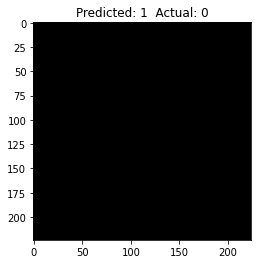

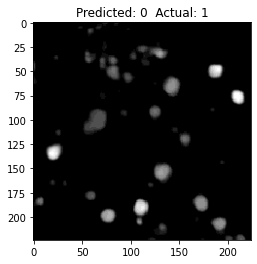

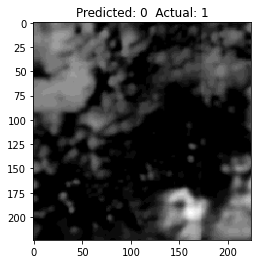

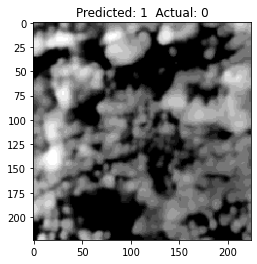

Confusion Matrix:
 [[1132  530]
 [ 340 1066]]
True Positives: 1066
False Positives: 530
True Negatives: 1132
False Negatives: 340
Precision: 0.6679
Recall: 0.7582
acc %
93.28552803129074
total INCORRECT total examples in val number of correct examples in val
103 1534 1431
val loss
0.2754122032996418
acc %
93.28552803129074
total INCORRECT total examples in val number of correct examples in val
103 1534 1431
val loss
0.2754122032996418


In [22]:
model2 = CustomResNet()
model2.load_state_dict(torch.load('resnet.pt'))
model2.eval()
val_loss = 0.0
correct = 0
total = 0
import matplotlib.pyplot as plt  # Import for image display

with torch.no_grad():
  for inputs, labels in val_loader:
    outputs = model2(inputs)
    loss = criterion(outputs, labels)
    val_loss += loss.item() * inputs.size(0)
    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

    # Check for misclassified examples and display them
    misclassified_inds = (predicted != labels).nonzero(as_tuple=True)[0]
    for misclassified_ind in misclassified_inds:
        if misclassified_ind % 1000 == 0:
            misclassified_image = inputs[misclassified_ind].cpu().squeeze()  # Get misclassified image
            
            # Normalize and convert to numpy format for plotting (if applicable)
            #misclassified_image = misclassified_image.permute(1, 2, 0)  # Permute for channels-first format
            # ... normalization steps specific to your data (if needed)
            misclassified_image = misclassified_image.numpy()
            
            plt.imshow(misclassified_image,cmap='gray')
            plt.title(f"Predicted: {predicted[misclassified_ind].item()}  Actual: {labels[misclassified_ind].item()}")
            plt.show()  # Display the misclassified image

  # Rest of the code (printing accuracy and loss)
# Calculate confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Extract true positives, negatives, false positives, and negatives
tn, fp, fn, tp = cm.ravel()

# Calculate Precision, Recall
precision = tp / (tp + fp)
recall = tp / (tp + fn)

# Print results (you can modify this for your needs)
print(f"Confusion Matrix:\n {cm}")
print(f"True Positives: {tp}")
print(f"False Positives: {fp}")
print(f"True Negatives: {tn}")
print(f"False Negatives: {fn}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print('acc %')
print(correct/total * 100)
print('total INCORRECT', 'total examples in val', 'number of correct examples in val')
print(total-correct, total, correct)
print('val loss')
print(val_loss / len(val_loader.dataset))

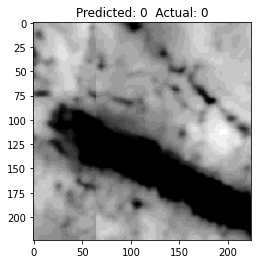

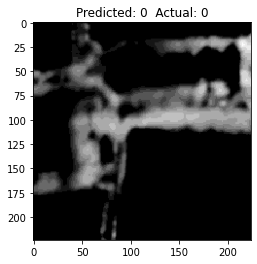

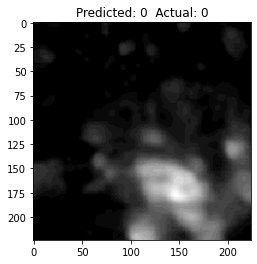

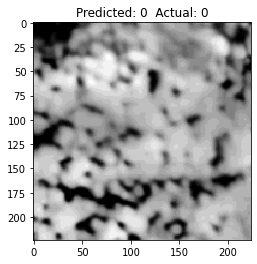

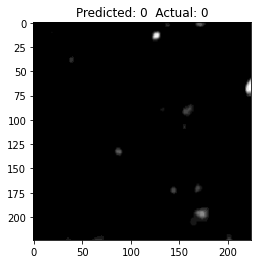

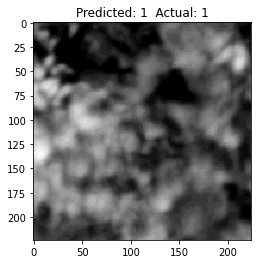

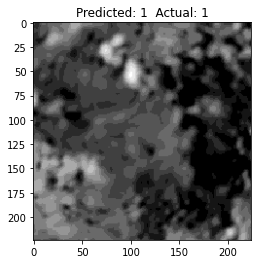

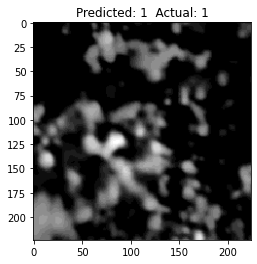

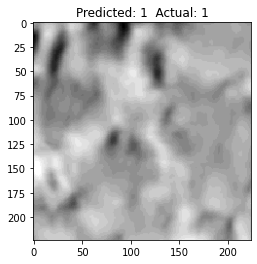

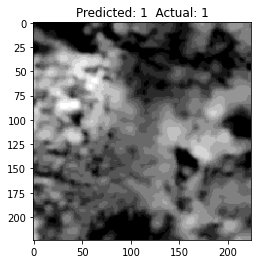

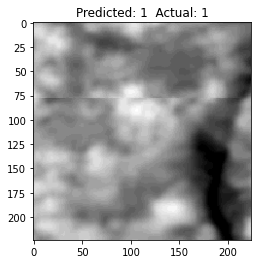

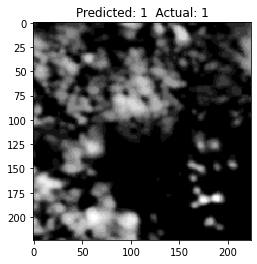

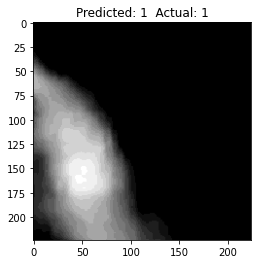

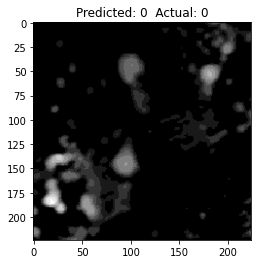

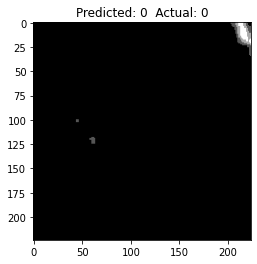

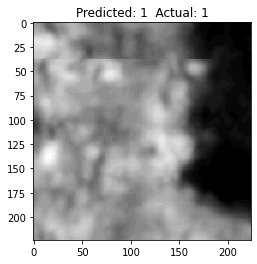

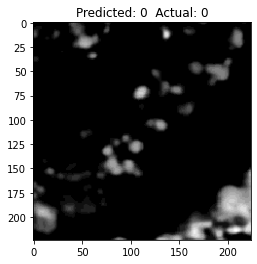

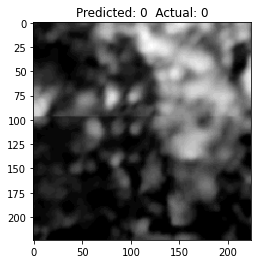

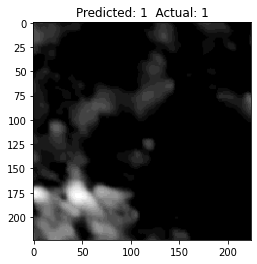

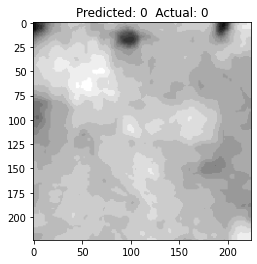

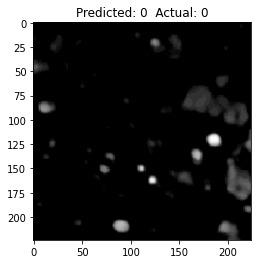

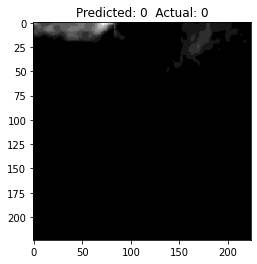

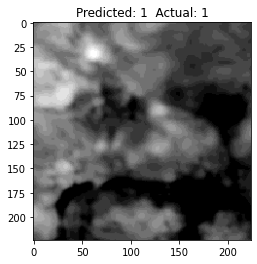

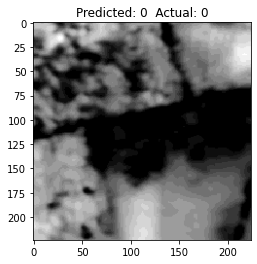

KeyboardInterrupt: 

In [18]:
model2 = CustomResNet()
model2.load_state_dict(torch.load('resnet.pt'))
model2.eval()
val_loss = 0.0
correct = 0
total = 0
import matplotlib.pyplot as plt  # Import for image display

with torch.no_grad():
  for inputs, labels in val_loader:
    outputs = model2(inputs)
    loss = criterion(outputs, labels)
    val_loss += loss.item() * inputs.size(0)
    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

    # Check for misclassified examples and display them
    good_inds = (predicted == labels).nonzero(as_tuple=True)[0]
    for ind in good_inds:
      if ind % 10000 == 0:
          good_image = inputs[ind].cpu().squeeze()  # Get misclassified image
          good_image = good_image.numpy()
    
          plt.imshow(good_image,cmap='gray')
          plt.title(f"Predicted: {predicted[ind].item()}  Actual: {labels[ind].item()}")
          plt.show()  # Display the misclassified image

  # Rest of the code (printing accuracy and loss)

print('acc %')
print(correct/total * 100)
print('total INCORRECT', 'total examples in val', 'number of correct examples in val')
print(total-correct, total, correct)
print('val loss')
print(val_loss / len(val_loader.dataset))

In [47]:

def get_feature_maps(model, images):
  """
  Extracts feature maps from the last convolutional layer for a batch of images.
  """
  features = []
  def hook(module, input, output):
    features.append(output.detach())
  handle = model.resnet.layer4[1].register_forward_hook(hook)
  _ = model(images)
  handle.remove()
  return features

def calculate_cam_batch(feature_maps, weights):
  """
  Calculates Class Activation Maps for a batch of images.
  """
#  cams = torch.zeros(feature_maps[0].size(0), feature_maps[0].size()[1:])
  batch_size, channel, height, width = feature_maps[0].size()
  cams = torch.zeros(batch_size, channel, height, width)
  #for i, weight in enumerate(weights):
  #  cams += weight * feature_maps[0][i, :, :]
  return cams

def visualize_cam_batch(model, val_loader, target_class, device):
  """
  Visualizes Class Activation Maps overlaid on validation images (batch-wise).
  """
  # Get model on device (if using GPU)
  model.to(device)

  # Iterate over validation loader
  for images, labels in val_loader:
    images = images.to(device)  # Send images to device

    # Get feature maps
    feature_maps = get_feature_maps(model.eval(), images)

    # Get weights for the target class
    params = list(model.resnet.fc.parameters())  # Assuming classifier at the end
    target_layer = params[-1]  # Last layer is the linear layer
    #weights = target_layer[target_class, :]  # Weights for target class
    weights = target_layer[target_class]
    
    # Calculate CAMs
    cams = calculate_cam_batch(feature_maps, weights)

    # Normalize and resize CAMs to image size (assuming all images same size)
    for i in range(len(cams)):
      cam = cams[i]
      cam = cam - torch.min(cam)  # Normalize between 0-1
      cam = cam / torch.max(cam)
      cam = torch.nn.functional.interpolate(cam.unsqueeze(0), size=(images.size(2), images.size(3)), mode='bilinear')

      # Convert to numpy and visualize (you can modify this loop for each image)
      cam = cam.squeeze().cpu().numpy()
      # Apply the CAM to the grayscale image (adjust alpha for visualization)
      heatmap = (images.squeeze(0).cpu().numpy()[i] * 0.5 + cam * 0.5)
      # You can use OpenCV or Matplotlib for visualization here
      # ...

# Example usage
model = CustomResNet()
model.load_state_dict(torch.load('resnet.pt'))  # Load weights
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Assuming your validation data loader is called val_loader
visualize_cam_batch(model, val_loader, target_class=0, device=device)

KeyboardInterrupt: 

In [38]:

from pytorch_grad_cam import GradCAM
class FeatureExtractor(nn.Module):
  def __init__(self, model):
    super(FeatureExtractor, self).__init__()
    self.model = model
    self.features = None

  def forward(self, x):
    # Forward pass through the original model layers
    for name, module in self.model._modules.items():
      if name == 'last_conv_layer_name':  # Replace with actual layer name
        self.features = module(x)  # Capture features before GAP
      x = module(x)
    return x

model = CustomResNet()
model.load_state_dict(torch.load('resnet.pt'), strict=False)  # Set strict=False to ignore unexpected keys
model.eval()
model = FeatureExtractor(model)
target_layers = model.features

cam = GradCAM(model=model, target_layers=target_layers)
for inputs, labels in val_loader:
    grayscale_cam = cam(input_tensor=inputs, targets=targets)

grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=False)

AttributeError: 'FeatureExtractor' object has no attribute 'layer4'

In [36]:

'''
from gradcam import models as gcmodels  # Import the ResNet class

class FeatureExtractor(nn.Module):
  def __init__(self, model):
    super(FeatureExtractor, self).__init__()
    self.model = model
    self.features = None

  def forward(self, x):
    # Forward pass through the original model layers
    for name, module in self.model._modules.items():
      if name == 'last_conv_layer_name':  # Replace with actual layer name
        self.features = module(x)  # Capture features before GAP
      x = module(x)
    return x

def calculate_CAM(model, features, target_label):
  grad_cam = gcmodels.ResNet(model = model.resnet)  # Wrap model for Grad-CAM
  target_layers = [model.resnet.layer4[1]]  # Replace with desired layer(s) for CAM (last conv layer of block 4 here)
  grayscale_cam = grad_cam(target_layers=target_layers, inputs=features, targets=target_label)
  grayscale_cam = grayscale_cam[0, 0]  # Extract channel and single batch data

  # Normalize and convert to RGB (assuming 3 channels for your image)
  cam = grayscale_cam.unsqueeze(0)  # Add channel dimension
  cam = F.relu(cam)  # Apply ReLU activation
  cam = cam / torch.max(cam)  # Normalize
  cam = cam.repeat(3, 1, 1)  # Repeat for RGB channels (if applicable)
  return cam

# Wrap your model with the feature extractor
model = CustomResNet()
model.load_state_dict(torch.load('resnet.pt'), strict=False)  # Set strict=False to ignore unexpected keys
model.eval()

# Wrap the model with FeatureExtractor (optional)
#model = FeatureExtractor(model)
# Assuming feature maps are stored in 'features'
for inputs, labels in val_loader:
  # ... rest of your code
  outputs = model(inputs)
  # Access feature maps from the model (using hook or model modification)
  #features = model.features  # Example for hook approach

  features = model.resnet.layer4[1]
  target_label = torch.tensor(0)
  # Calculate CAM using your preferred method (refer to libraries below)
  cam = calculate_CAM(model, features, target_label)
  # Visualize or analyze the CAM (refer to libraries below)

'''

ModuleNotFoundError: No module named 'gradcam'

In [34]:
!pip show grad-cam

Name: grad-cam
Version: 1.5.0
Summary: Many Class Activation Map methods implemented in Pytorch for classification, segmentation, object detection and more
Home-page: https://github.com/jacobgil/pytorch-grad-cam
Author: Jacob Gildenblat
Author-email: jacob.gildenblat@gmail.com
License: 
Location: /home/angelats11/anaconda3/lib/python3.9/site-packages
Requires: torch, ttach, numpy, scikit-learn, matplotlib, torchvision, Pillow, tqdm, opencv-python
Required-by: 


In [ ]:
import torch
from torch import nn

num_classes = 2
'''
# Define the model
class SimpleCNN(nn.Module):
  def __init__(self, num_classes):
    super(SimpleCNN, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # Input channels=1 (grayscale)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
    self.fc1 = nn.Linear(112 * 112 * 64, 64)  # Assuming input image is normalized
    self.fc2 = nn.Linear(64, num_classes)

  def forward(self, x):
    x = self.pool(nn.functional.relu(self.conv1(x)))
    x = self.pool(nn.functional.relu(self.conv2(x)))
    x = torch.flatten(x, start_dim=0, end_dim=1)  # Flatten after pooling
    x = nn.functional.relu(self.fc1(x))
    x = self.fc2(x)
    return x

# Create an instance of the model
model = SimpleCNN(num_classes)
'''

import torch
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(128 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, 2)  

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(-1, 128 * 56 * 56)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the model
model = CNN()


In [34]:
dropout_prob = .3
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 39 * 39, 64)  # Adjusted for 156x156 input
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x

class ComplexCNN(nn.Module):
    def __init__(self, num_classes=2, dropout_prob=0.5):
        super(ComplexCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(128 * 19 * 19, 512)  # Adjusted for 156x156 input
        self.relu4 = nn.ReLU()
        self.dropout = nn.Dropout(dropout_prob)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool3(x)

        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x


class LSTMCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(LSTMCNN, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        
        # Recurrent layers
        self.lstm = nn.LSTM(128 * 50 * 50, 256, batch_first=True)
        
        # Fully connected layers
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # Convolutional layers
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        
        # Reshape for recurrent layer
        x = x.view(-1, 128 * 50 * 50)
        
        # Recurrent layer
        x, _ = self.lstm(x.unsqueeze(1))  # Add a temporal dimension
        
        # Global average pooling
        x = x.mean(dim=1)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

import torchvision.models as models

class SmallComplexModel(nn.Module):
    def __init__(self, num_classes=2):
        super(SmallComplexModel, self).__init__()
        
        # Load the pre-trained MobileNetV2 model
        mobilenet_v2 = models.mobilenet_v2(pretrained=True)
        
        # Remove the classification head of MobileNetV2
        self.features = mobilenet_v2.features
        
        # Add custom layers for your task
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(1280, num_classes)
        )

    def forward(self, x):
        # Feature extraction with MobileNetV2
        x = self.features(x)
        
        # Global average pooling
        x = self.avgpool(x)
        
        # Reshape for fully connected layer
        x = x.view(x.size(0), -1)
        
        # Fully connected layers
        x = self.fc(x)
        
        return x

# Create an instance of the model
#model = SmallComplexModel().to(device)

class ResModel(nn.Module):
    def __init__(self, num_classes=2):
        super(ResModel, self).__init__()
        
        # Load the pre-trained MobileNetV2 model
        resnet18 = models.resnet18(pretrained=True)
        
       # Remove the classification head of ResNet18
        self.features = nn.Sequential(*list(resnet18.children())[:-1])

        # Add custom layers for your task
#        self.fc = nn.Sequential(
#            nn.Flatten(),
#            nn.Linear(512, num_classes)
#        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 512),  # You can adjust the output size of the linear layer
            nn.ReLU(),           # Add activation function
            nn.Dropout(p=dropout_prob),  # Dropout layer
            nn.Linear(512, num_classes)
        )


    def forward(self, x):
        # Feature extraction with ResNet18
        x = self.features(x)

        # Fully connected layers
        x = self.fc(x)

        return x

model = ResModel().to(device)
        

# Print the model architecture
#print(model)
# Instantiate the model
#complex_model = ComplexCNN().to(device)
#model = ComplexCNN().to(device)
# Instantiate the model
#complex_model = ComplexCNN().to(device)
#model = ComplexCNN().to(device)

/home/angelats11/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


(4464, 224, 224)
[0 0 0 ... 1 1 1]
(4464,)


RuntimeError: Given groups=1, weight of size [16, 3, 3, 3], expected input[64, 1, 224, 224] to have 3 channels, but got 1 channels instead

In [5]:
shape = (160,160,3)

from torch.utils.data.sampler import SubsetRandomSampler

class CustomDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.file_list = os.listdir(data_dir)

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_name = os.path.join(self.data_dir, self.file_list[idx])
        if img_name in anoms:
          #return torch.zeros(50,50,3), -1
          return torch.zeros(160,160,3)
        image = np.squeeze(np.load(img_name, allow_pickle=True))
        #image = np.squeeze(np.load(img_name))[:,53:103,53:103]#.unsqueeze(0).unsqueeze(0)
        #print(image)
        #print(image.shape)
        #print(image)
        #if self.transform:
        #    image = self.transform(image)
        label = 0 if "orchard" in self.data_dir else 1  # Assuming "orchard" is class 0 and "forest" is class 1
        return image, label, img_name

# Data augmentation and normalization
transform = transforms.Compose([transforms.ToTensor()])#, transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])#, transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Create data loaders for training and validation
#orchard_dataset = CustomDataset(orchard_path, transform)
#forest_dataset = CustomDataset(forest_path, transform)
dataset = CustomDataset(orchard_path, transform) + CustomDataset(forest_path, transform)
split_ratio = 0.8
num_data = len(dataset)
split = int(np.floor(split_ratio * num_data))
indices = list(range(num_data))

indices = [idx for idx in indices if dataset[idx][1] != -1]

np.random.shuffle(indices)


# Create data samplers for training and testing sets
train_indices, test_indices = indices[:split], indices[split:]
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

# Create data loaders for training and testing
train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)
# Use DataLoader to handle batching and shuffling
#orchard_loader = DataLoader(orchard_dataset, batch_size=batch_size, shuffle=True)
#forest_loader = DataLoader(forest_dataset, batch_size=batch_size, shuffle=True)

In [22]:
'''
import torch.nn as nn

class rgb50CNN(nn.Module):
    def __init__(self, num_classes=2):
        super(rgb50CNN, self).__init__()
        # Define your model layers
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 12 * 12, 64)  # Adjusted for 50x50 input
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = x.view(x.size(0), -1)  # Ensure correct flattening
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x

# Create an instance of the modified model
model = rgb50CNN().to(device)
'''

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [9]:
import torch.nn.functional as F
num_epochs = 30

def train(model, train_loader, optimizer, criterion):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for batch, (images, labels, img_name) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_accuracy = 100 * correct / total
    return total_loss / (batch + 1), train_accuracy

def validate(model, val_loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    misclassified_paths = []
    with torch.no_grad():
        for batch, (images, labels, img_name) in enumerate(val_loader):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            incorrect_indices = (predicted != labels).nonzero()
            misclassified_paths.extend([img_name[i] for i in incorrect_indices])


    val_accuracy = 100 * correct / total
    return total_loss / (batch + 1), val_accuracy, misclassified_paths


In [ ]:

# ... (optimizer and criterion)

# Training loop with validation
trnl = []
vall = []
trna=[]
vala=[]
epochs = [x for x in range(num_epochs)]
mistakes = []
for epoch in range(num_epochs):
    train_loss, train_accuracy = train(model, train_loader, optimizer, criterion)
    val_loss, val_accuracy, misclf = validate(model, test_loader, criterion)
    trnl.append(train_loss)
    vall.append(val_loss)
    trna.append(train_accuracy)
    vala.append(val_accuracy)
    print(f"Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")
    if epoch == 20:
        print('epoch 20 erros')
    if epoch == num_epochs-1:
        print('last epoch errors')
        print(misclf)
        mistakes = misclf
        
print("Training complete.")
import matplotlib.pyplot as plt
plt.plot(epochs,trnl,label='train loss')
plt.plot(epochs,vall,label='val loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

plt.plot(epochs,trna,label='train acc')
plt.plot(epochs,vala,label='val acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

Epoch [1/30] - Train Loss: 0.4069, Train Acc: 82.00%, Val Loss: 0.4287, Val Acc: 84.25%
Epoch [2/30] - Train Loss: 0.4379, Train Acc: 82.00%, Val Loss: 0.4699, Val Acc: 79.50%
Epoch [3/30] - Train Loss: 0.3767, Train Acc: 85.00%, Val Loss: 0.4481, Val Acc: 84.50%
Epoch [4/30] - Train Loss: 0.3571, Train Acc: 85.31%, Val Loss: 0.3518, Val Acc: 85.50%
Epoch [5/30] - Train Loss: 0.3640, Train Acc: 86.25%, Val Loss: 0.4041, Val Acc: 82.75%
Epoch [6/30] - Train Loss: 0.3536, Train Acc: 86.31%, Val Loss: 0.3646, Val Acc: 85.00%
Epoch [7/30] - Train Loss: 0.3276, Train Acc: 86.38%, Val Loss: 0.3249, Val Acc: 85.75%


In [ ]:
#model.train(train_loader)

ValueError: ignored

NEXT: THE PART WHERE WE TRAIN ON SENTINEL-2 ALONE AS A BENCHMARK (BOTTOM TIE PERFOMANCE TO BEAT)


In [ ]:
#orchard_path = "mountdata/euroorchards2-50m"
#forest_path = "mountdata/euroforests2-50m"

orchard_path = 'mountdata/zaforchards2-50m'
forest_path = 'mountdata/zafforests2-50m'

In [ ]:
#import tifffile
from PIL import Image
import rasterio as rio

#import cv2
#import gdal
from torch.utils.data.sampler import SubsetRandomSampler
#import imagecodecs
from skimage import io

anomalies = []
class CustomDatasetS2(Dataset):
    def __init__(self, data_dir, transform=None, num_channel=12):
        self.data_dir = data_dir
        self.transform = transform
        self.file_list = os.listdir(data_dir)
        self.num_channel = num_channel

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_name = os.path.join(self.data_dir, self.file_list[idx])
        if img_name.endswith('.tif'):
            if img_name in anomalies:
                pass
            with rio.open(img_name) as img :
                image= img.read()
                image = image.astype('float32')
    
                image = image[:self.num_channel,2:52,2:52]
                image = np.transpose(image,(1,2,0))
                #print
                if image.shape != (50,50,self.num_channel):
                    print('anomaly')
                    anomalies.append(img_name)
                    return torch.zeros(50, 50,self.num_channel), -1
                    #return torch.zeros(10, 10,12), -1
                
                if self.transform:
                    image = self.transform(image)
            label = 0 if "orchard" in self.data_dir else 1  # Assuming "orchard" is class 0 and "forest" is class 1
            return image, label

transform = transforms.Compose([transforms.ToTensor()])
bicubtransform = transforms.Compose([transforms.ToPILImage(), transforms.Resize((160, 160), interpolation=Image.BICUBIC), transforms.ToTensor()])

datasets2 = CustomDatasetS2(orchard_path, transform, 3) + CustomDatasetS2(forest_path, transform, 3)
#split_ratio = 0.8
#num_data = len(datasets2)
#split = int(np.floor(split_ratio * num_data))
#indices = list(range(num_data))
#indices = [idx for idx in indices if datasets2[idx][1] != -1]
#np.random.shuffle(indices)


# Create data samplers for training and testing sets
train_indices, test_indices = indices[:split], indices[split:]
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

# Create data loaders for training and testing
train_loader = DataLoader(datasets2, batch_size=batch_size, sampler=train_sampler)
test_loader = DataLoader(datasets2, batch_size=batch_size, sampler=test_sampler)

print(anomalies)

In [ ]:
#input_size = (3, 50, 50)  # Assuming 3 channels, 160x160 size
#dummy_input = torch.randn(1, *input_size).to(device)  # Create a dummy input
#output = model(dummy_input)

In [ ]:
import rasterio as rio
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# Training loop with validation
trnl = []
vall = []
trna=[]
vala=[]
epochs = [x for x in range(num_epochs)]
mistakes_s2 = []
for epoch in range(num_epochs):
    train_loss, train_accuracy = train(model, train_loader, optimizer, criterion)
    val_loss, val_accuracy, misclf = validate(model, test_loader, criterion)
    trnl.append(train_loss)
    vall.append(val_loss)
    trna.append(train_accuracy)
    vala.append(val_accuracy)
    print(f"Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")
    if epoch == 20:
        print('epoch 20 erros')
    if epoch == num_epochs-1:
        print('last epoch errors')
        print(misclf)
        mistakes_s2 = misclf
        
print("Training complete.")
import matplotlib.pyplot as plt
plt.plot(epochs,trnl,label='train loss')
plt.plot(epochs,vall,label='val loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

plt.plot(epochs,trna,label='train acc')
plt.plot(epochs,vala,label='val acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

Training complete.


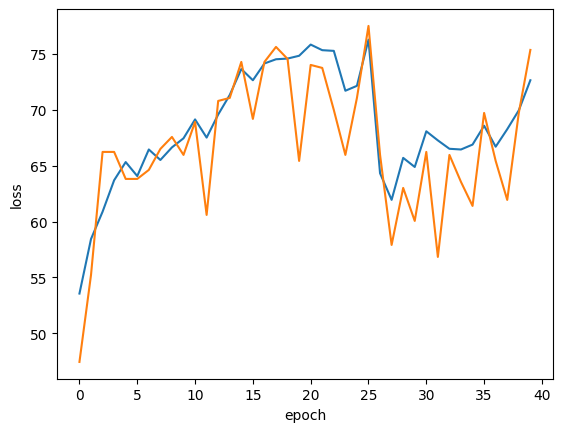

In [14]:
print("Training complete.")
import matplotlib.pyplot as plt
plt.plot(epochs,trna,label='train loss')
plt.plot(epochs,vala,label='val loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

Training complete.


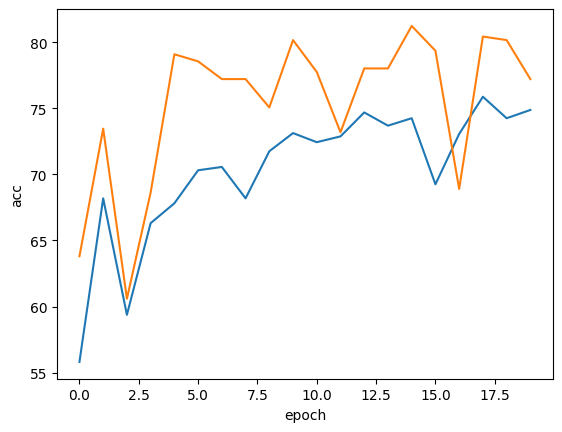

In [ ]:
print("Training complete.")
import matplotlib.pyplot as plt
plt.plot([x for x in range(20)],trna,label='train loss')
plt.plot([x for x in range(20)],vala,label='val loss')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.show()

In [ ]:
# Convert the NumPy array to a NumPy array with data type 'uint8'

class CustomDatasetS2(Dataset):
    def __init__(self, data_dir, transform=None, num_channel=12):
        self.data_dir = data_dir
        self.transform = transform
        self.file_list = os.listdir(data_dir)
        self.num_channel = num_channel

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_name = os.path.join(self.data_dir, self.file_list[idx])
        if img_name.endswith('.tif'):
            if img_name in anomalies:
                pass
            with rio.open(img_name) as img :
                image= img.read()
                image = image.astype('float32')
                image = (image * 255).astype('uint8')
                image = image[:self.num_channel,2:52,2:52]
                image = np.transpose(image,(1,2,0))
                #print
                if image.shape != (50,50,self.num_channel):
                    print('anomaly')
                    anomalies.append(img_name)
                    return torch.zeros(50, 50,self.num_channel), -1
                    #return torch.zeros(10, 10,12), -1
                
                if self.transform:
                    image = self.transform(image)
            label = 0 if "orchard" in self.data_dir else 1  # Assuming "orchard" is class 0 and "forest" is class 1
            return image, label


In [ ]:
num_epochs = 40
datasets2bicub = CustomDatasetS2(orchard_path, bicubtransform, 3) + CustomDatasetS2(forest_path, bicubtransform, 3)

# Create data loaders for training and testing
train_loader = DataLoader(datasets2bicub, batch_size=batch_size, sampler=train_sampler)
test_loader = DataLoader(datasets2bicub, batch_size=batch_size, sampler=test_sampler)

model = ResModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# Training loop with validation
trnl = []
vall = []
trna=[]
vala=[]
epochs = [x for x in range(num_epochs)]
mistakes_bicub = []
for epoch in range(num_epochs):
    train_loss, train_accuracy = train(model, train_loader, optimizer, criterion)
    val_loss, val_accuracy, misclf = validate(model, test_loader, criterion)
    trnl.append(train_loss)
    vall.append(val_loss)
    trna.append(train_accuracy)
    vala.append(val_accuracy)
    print(f"Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")
    if epoch == 20:
        print('epoch 20 erros')
    if epoch == num_epochs-1:
        print('last epoch errors')
        print(misclf)
        mistakes_bicub = misclf
        
print("Training complete.")
import matplotlib.pyplot as plt
plt.plot(epochs,trnl,label='train loss')
plt.plot(epochs,vall,label='val loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

plt.plot(epochs,trna,label='train acc')
plt.plot(epochs,vala,label='val acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()